# **CS224W - Colab 5**

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/scpd-proed/XCS224W-Colab5/blob/main/Notebook/XCS224W_Colab5.ipynb)

Before opening the colab with the badge, you would need to allow Google Colab to access the GitHub private repositories. Please check therefore [this tutorial](https://colab.research.google.com/github/googlecolab/colabtools/blob/master/notebooks/colab-github-demo.ipynb#:~:text=Navigate%20to%20http%3A%2F%2Fcolab,to%20read%20the%20private%20files.).

If colab is opened with this badge, make sure please **save copy to drive** in 'File' menu before running the notebook.

In this final Colab we will continue experimenting with advanced topics in GNNs. Specifically, we will look at different techniques for scaling up GNNs using PyTorch Geometric, DeepSNAP and NetworkX. In the previous Colab we worked with PyTorch Geometric's `NeighborSampler` to scale up training and testing on the OGB `arxiv` dataset and now we will be using DeepSNAP and NetworkX, to implement our own simplified version of `NeighborSampler` and run experiments with different sampling ratios on the Cora graph.

Lastly, we will partition the Cora graph into clusters by using different partition algorithms and then train the models using a vanilla Cluster-GCN.

**Note**: Make sure to **sequentially run all the cells in each section**, so that the intermediate variables / packages will carry over to the next cell

# Device
You likely will want to us a GPU for this Colab.

Please click `Runtime` and then `Change runtime type`. Then set the `hardware accelerator` to **GPU**.

# Setup
As discussed in the first Colabs, the installation of PyG on Colab can be a little bit tricky. First let us check which version of PyTorch you are running

In [9]:
# Install PyTorch
import os
if 'IS_GRADESCOPE_ENV' not in os.environ:
    !pip install torch==2.5.1+cu124 -f https://download.pytorch.org/whl/torch

Looking in links: https://download.pytorch.org/whl/torch


In [10]:
import torch
print("PyTorch has version {}".format(torch.__version__))

PyTorch has version 2.5.1+cu124


# Installation

In [11]:
# Install torch geometric
if 'IS_GRADESCOPE_ENV' not in os.environ:
  !pip install torch-scatter -f https://pytorch-geometric.com/whl/torch-2.5.1+cu124.html
  !pip install torch-sparse -f https://pytorch-geometric.com/whl/torch-2.5.1+cu124.html
  !pip install torch-geometric
  !pip install -q ogb
  # Fix for Deepsnap PyG 2.4.x compatibility issue (https://github.com/snap-stanford/deepsnap/issues/53)
  !pip install -q git+https://github.com/SebastianHurubaru/deepsnap.git


Looking in links: https://pytorch-geometric.com/whl/torch-2.5.1+cu124.html
Looking in links: https://pytorch-geometric.com/whl/torch-2.5.1+cu124.html
  Preparing metadata (setup.py) ... done


In [12]:
import torch_geometric
torch_geometric.__version__

'2.6.1'

# 1) Neighbor Sampling with Different Ratios

We will implement our own simplified version of Neighbor Sampling using DeepSNAP and NetworkX. Then we will use our sampler to train models with different neighborhood sampling ratios and compare their performance.

To make our experiments faster, we will use the Cora graph.

## Setup

In [13]:
import copy
import torch
import random
import numpy as np
import pandas as pd
import networkx as nx
import torch.nn as nn
import torch.nn.functional as F

from torch_geometric.nn import SAGEConv
from torch.utils.data import DataLoader
from torch_geometric.datasets import Planetoid
from torch.nn import Sequential, Linear, ReLU
from deepsnap.dataset import GraphDataset
from deepsnap.graph import Graph

if 'IS_GRADESCOPE_ENV' not in os.environ:
  pyg_dataset = Planetoid('./tmp', "Cora")

## GNN Model

We use a simple GraphSage GNN model, which we provide to you below. Similar to in section one, notice the slightly different implementations of the forward method depending on the data `mode`. When `mode = "batch"` we use Neighbor sampling. Thus, the data parameter contains our graph's node features (`x`) and a list `edge_indices` containing the connectivity of each GNN layer (i.e. an edge_index for each layer, defining the bipartite neighborhood computation graph).

**NOTE:** Refer to sections *Neighbor Sampling* and *PyTorch Geometric Neighbor Sampler* from Colab4 for a detailed overview of the Neighbor Sampling technique.

In [14]:
class GNN(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, args):
        super(GNN, self).__init__()
        self.dropout = args['dropout']
        self.num_layers = args['num_layers']

        self.convs = nn.ModuleList()
        self.bns = nn.ModuleList()

        self.convs.append(SAGEConv(input_dim, hidden_dim))
        self.bns.append(nn.BatchNorm1d(hidden_dim))

        for l in range(self.num_layers - 2):
            self.convs.append(SAGEConv(hidden_dim, hidden_dim))
            self.bns.append(nn.BatchNorm1d(hidden_dim))
        self.convs.append(SAGEConv(hidden_dim, hidden_dim))

        self.post_mp = nn.Linear(hidden_dim, output_dim)

    def forward(self, data, mode="batch"):
        # Observe the difference between mode == "batch" and mode == "all".
        # In mode == "batch" we pass in an edge index for each conv layer
        # corresponding to that layer's bipartite graph structure.
        if mode == "batch":
            edge_indices, x = data
            for i in range(len(self.convs) - 1):
                edge_index = edge_indices[i]
                x = self.convs[i](x, edge_index)
                x = self.bns[i](x)
                x = F.relu(x)
                x = F.dropout(x, p=self.dropout, training=self.training)
            x = self.convs[-1](x, edge_indices[len(self.convs) - 1])
        else:
            x, edge_index = data.node_feature, data.edge_index
            for i in range(len(self.convs) - 1):
                x = self.convs[i](x, edge_index)
                x = self.bns[i](x)
                x = F.relu(x)
                x = F.dropout(x, p=self.dropout, training=self.training)
            x = self.convs[-1](x, edge_index)
        x = self.post_mp(x)
        x = F.log_softmax(x, dim=1)
        return x

## Implementing Neighbor Sampling

Now let's take a stab at implementing our own basic version of Neighbor Sampling using DeepSNAP and NetworkX. To decompose the process, we will define several helper functions before finally defining our own `neighbor_sampling` function!

**NOTE:** Before working through this section, we highly recommend reviewing sections `Neighbor Sampling` and `PyTorch Geometric Neighbor Sampler`. Specifically, it is important to understand how we explicitly define an `edge_index` for each GNN layer, representing the bipartite computation graph connecting the `target_nodes` that we are embedding for that layer to their relevant neighbors from the previous layer needed for message passing.

## **Question 1.1a**: Implementing the `sample_neighbors` function. (5 points)

In [15]:
def sample_neighbors(nodes, G, ratio, all_nodes):
    # TODO: Implement a function that takes as input a set of nodes,
    # a NetworkX graph G, a neighbor sampling ratio, and a set containing all nodes
    # and returns:
    #   1. A set of the sampled nodes
    #   2. A set union between `all_nodes` and the newly sampled neighbor nodes.
    #      This allows us to track the nodes needed across all message passing layers.
    #   3. The set of edges connecting the sampled neighboring nodes to our input
    #      set of nodes. Represents a bi-partite graph between targets (nodes)
    #      and source (neighbor) nodes.

    neighbors = set()
    edges = []

    ############# Your code here ############
    ## (~8-10 line of code)
    ## Note:
    ## 1. You will will need to sample neighbors from each node given to you in
    ##    `nodes` list.
    ##    Hint: Use graph `G` to assist in obtaining the neighbors of each node.
    ## 2. The number of neighbors to be sampled based on the `ratio` parameter
    ##    must be rounded **down** to get an integer value
    ## 3. Randomly sample neighbors without replacement (i.e. the same neighbors
    ##    should not be selected more than once for a given node)
    ## 4. The neighbors are stored in a set data structure to ensure that duplicates
    ##    are avoided.  This is useful as the set union will be taken with `all_nodes`.
    ## 5. The edges list should contain all edges sampled in the form of a tuple
    ##    of (neighbor, node)
    for node in nodes:
        all_neighbors = [n for n in G.neighbors(node)]
        num_neighbors = int(len(all_neighbors) * ratio)
        sampled_neighbors = random.sample(all_neighbors, num_neighbors)
        for neighbor in sampled_neighbors:
            neighbors.add(neighbor)
            edges.append((neighbor, node))
    ##########################################
    return neighbors, neighbors.union(all_nodes), edges

if 'IS_GRADESCOPE_ENV' not in os.environ:
  graphs_train, _, _ = \
      GraphDataset.pyg_to_graphs(pyg_dataset, verbose=True, fixed_split=True)

  graph_train = graphs_train[0]

  nodes = [15, 16, 17]
  neighbors_full, _, _ = sample_neighbors(nodes, graph_train.G, 1, set())
  neighbors_sampled, _, _ = sample_neighbors(nodes, graph_train.G, 0.3, set())
  print ("Neighbors with ratio = 1:", neighbors_full)
  print ("Neighbors with ratio = 0.3:", neighbors_sampled)
  # Note that this is not expected to be 0.3. Since we apply
  # our sampling ratio for each node, the number of neighbors
  # for each node may not evenly divide by the ratio
  print ("Ratio of sampled neighbors:", len(neighbors_sampled) / len(neighbors_full))

Index fields: val_mask ignored.
Index fields: train_mask ignored.
Index fields: test_mask ignored.
Neighbors with ratio = 1: {1632, 1090, 1315, 1316, 1093, 970, 2444, 2642, 1271, 24, 927, 2140, 2367}
Neighbors with ratio = 0.3: {24, 2444, 2367}
Ratio of sampled neighbors: 0.23076923076923078


## Tensor transformation and node relabeling helper functions.

In [16]:
def nodes_to_tensor(nodes):
    """
      Transforms a set of nodes into a node index tensor.
    """

    node_label_index = torch.tensor(list(nodes), dtype=torch.long)
    return node_label_index


def edges_to_tensor(edges):
    """
      Transforms a list of undirected edges into the corresponding PyG
      edge_index tensor representation. Notice that we explicitly make
      sure to include both edge directions.
    """

    edge_index = torch.tensor(list(edges), dtype=torch.long)
    edge_index = torch.cat([edge_index, torch.flip(edge_index, [1])], dim=0)
    edge_index = edge_index.permute(1, 0)

    return edge_index

def relabel(nodes, labeled_nodes, edges_list):
    """
      Relabel nodes with 0 based indeces.

      During the sampling process, we are likely to sample a list of
      non-continuous node ids. However, our GNN models rely on continuous
      0 based indexing to index into the rows of our node features matrix
      based on edges in the graph (edge_index)
    """

    relabeled_edges_list = []
    sorted_nodes = sorted(nodes)
    node_mapping = {node : i for i, node in enumerate(sorted_nodes)}
    for orig_edges in edges_list:
        relabeled_edges = []
        for edge in orig_edges:
            relabeled_edges.append((node_mapping[edge[0]], node_mapping[edge[1]]))
        relabeled_edges_list.append(relabeled_edges)
    relabeled_labeled_nodes = [node_mapping[node] for node in labeled_nodes]
    relabeled_nodes = [node_mapping[node] for node in nodes]

    return relabeled_edges_list, relabeled_nodes, relabeled_labeled_nodes, sorted_nodes


## **Question 1.1b**: Putting it all together - Implementing our own Neighbor Sampling function. (4 points)

Now that we've developed a better understanding of what the Neighbor Sampling function does, we will implement our own version of it. Instead of choosing $H_k$ number of samples at each layer, we will use a ratio of the number of neigbors that a givn node has. Can you think of the pros and cons of using a ratio of the number of neighbors for a node at different layers?  

In [23]:
def neighbor_sampling(graph, K=2, ratios=(0.1, 0.1, 0.1)):
    # TODO: Implement a function that performs Neighbor Sampling on an input
    # graph G for a K layer GNN. Notice that len(ratios) = K + 1. Ratios[-1]
    # determines size of our mini-batch (i.e. the number of labeled
    # nodes we sample computation graphs for).

    assert K + 1 == len(ratios)

    labeled_nodes = graph.node_label_index.tolist()
    random.shuffle(labeled_nodes)
    num = int(len(labeled_nodes) * ratios[-1])
    if num > 0:
        labeled_nodes = labeled_nodes[:num]
    nodes_list = [set(labeled_nodes)]
    edges_list = []
    all_nodes = labeled_nodes

    ############# Your code here ############
    ## (~4-6 line of code)
    ## Note:
    ## 1. Using your previously defined `sample_neighbors` function, build up the
    ##    edges_list for our K layer network.
    ## 2. nodes_list is a list where nodes_list[i] is set of nodes used for message
    ##    passing in layer i+1 of our GNN (i.e. level i in our computation graph).
    ##    Notice, nodes_list[-1] represents the target nodes we want to
    ##    embedd in the mini-batch.
    ## 3. edges_list is a list of the bi-partite edge conections between layers
    ##    in the computation graph.
    ## 4. all_nodes is used to track all the nodes needed for message passing.
    ## 5. Remember in a GNN, information flows from the base of the computation
    ##    graph to the root. How does this affect the way we add to the nodes_list
    ##    and edges_list, as well as how we read from ratios (ratios[-1]
    ##    represents the root nodes in our computation graph)?
    for i in range(K):
        nodes = nodes_list[i]
        neighbors, all_nodes, edges = sample_neighbors(nodes, graph.G, ratios[i], all_nodes)
        nodes_list.append(neighbors)
        edges_list.append(edges)
    nodes_list.reverse()
    edges_list.reverse()
    #########################################

    relabeled_edges_list, relabeled_all_nodes, relabeled_labeled_nodes, sorted_original_nodes = \
        relabel(all_nodes, labeled_nodes, edges_list)

    node_index = nodes_to_tensor(sorted_original_nodes)
    # All node features that will be used
    node_feature = graph.node_feature[node_index]
    edge_indices = [edges_to_tensor(edges) for edges in relabeled_edges_list]
    node_label_index = nodes_to_tensor(relabeled_labeled_nodes)
    orig_node_label_index = nodes_to_tensor(labeled_nodes)
    log = "Sampled {} nodes, {} edges, {} labeled nodes"
    print(log.format(node_feature.shape[0], edge_indices[0].shape[1] // 2, node_label_index.shape[0]))
    return node_feature, edge_indices, node_label_index, orig_node_label_index

if 'IS_GRADESCOPE_ENV' not in os.environ:
  # Need to define some basic test! Primarily to test whether they build
  # in the correct reverse order. So ideally something like ratio = (0.3, 0.5, 0.8).
  # Just need to check shapes.

  graphs_train, _, _ = \
      GraphDataset.pyg_to_graphs(pyg_dataset, verbose=True, fixed_split=True)

  graph_train = graphs_train[0]

  node_feature, edge_indices, node_label_index, _ = neighbor_sampling(graph_train, K=3, ratios=(0.5, 0.8, 1, 1))

Index fields: val_mask ignored.
Index fields: train_mask ignored.
Index fields: test_mask ignored.
Sampled 1938 nodes, 5293 edges, 140 labeled nodes


## Training and Testing

Additionally, notice that node classification task on Cora is a semi-supervised classification task, here we keep all the labeled training nodes (140 nodes) by setting the last ratio to 1.

In [24]:
def train(train_graphs, val_graphs, args, model, optimizer, mode="batch"):
    best_val = 0
    best_model = None
    accs = []
    graph_train = train_graphs[0]
    graph_train.to(args['device'])
    for epoch in range(1, 1 + args['epochs']):
        model.train()
        optimizer.zero_grad()
        if mode == "batch":
            node_feature, edge_indices, node_label_index, orig_node_index = neighbor_sampling(graph_train, args['num_layers'], args['ratios'])
            node_feature = node_feature.to(args['device'])
            node_label_index = node_label_index.to(args['device'])
            for i in range(len(edge_indices)):
                edge_indices[i] = edge_indices[i].to(args['device'])
            pred = model([edge_indices, node_feature])
            pred = pred[node_label_index]
            label = graph_train.node_label[orig_node_index]
        elif mode == "community":
            graph = random.choice(train_graphs)
            graph = graph.to(args['device'])
            pred = model(graph, mode="all")
            pred = pred[graph.node_label_index]
            label = graph.node_label[graph.node_label_index]
        else:
            pred = model(graph_train, mode="all")
            label = graph_train.node_label
            pred = pred[graph_train.node_label_index]
        loss = F.nll_loss(pred, label)
        loss.backward()
        optimizer.step()

        train_acc, val_acc, test_acc = test(val_graphs, model)
        accs.append((train_acc, val_acc, test_acc))
        if val_acc > best_val:
            best_val = val_acc
            best_model = copy.deepcopy(model)
        print(f'Epoch: {epoch:02d}, '
              f'Loss: {loss:.4f}, '
              f'Train: {100 * train_acc:.2f}%, '
              f'Valid: {100 * val_acc:.2f}% '
              f'Test: {100 * test_acc:.2f}%')
    return best_model, accs

def test(graphs, model, save_model_results=False, batch_type="batch", title=None):
    model.eval()
    accs = []

    for graph in graphs:
        graph = graph.to(args['device'])
        pred = model(graph, mode="all")
        label = graph.node_label
        pred = pred[graph.node_label_index].max(1)[1]
        acc = pred.eq(label).sum().item()
        acc /= len(label)
        accs.append(acc)

    if save_model_results:
      print ("Saving Model Predictions for Model:", batch_type, title)

      data = {}
      # The last dataset we test is the test graph
      data['pred'] = pred.view(-1).cpu().detach().numpy()
      data['label'] = label.view(-1).cpu().detach().numpy()

      df = pd.DataFrame(data=data)
      # Save locally as csv
      file_name = 'CORA_Node_' + batch_type
      if title is not None:
        file_name = file_name + "_" + title

      df.to_csv(file_name + '.csv', sep=',', index=False)

    return accs

In [25]:
args = {
    'device': torch.device('cuda' if torch.cuda.is_available() else 'cpu'),
    'dropout': 0.5,
    'num_layers': 2,
    'hidden_size': 64,
    'lr': 0.005,
    'epochs': 50,
    'ratios': (0.8, 0.8, 1),
}

In [26]:
def set_seed(seed=224):

    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.backends.cudnn.benchmark = False

## Full-Batch Training

As a baseline, we train our GNN model over the entire graph without any Neighbor Sampling.

In [21]:
if 'IS_GRADESCOPE_ENV' not in os.environ:

  set_seed()

  graphs_train, graphs_val, graphs_test = \
      GraphDataset.pyg_to_graphs(pyg_dataset, verbose=True, fixed_split=True)

  graph_train = graphs_train[0]
  graph_val = graphs_val[0]
  graph_test = graphs_test[0]

  model = GNN(graph_train.num_node_features, args['hidden_size'], graph_train.num_node_labels, args).to(args['device'])

  # Disable compile as this does not seem to work yet in PyTorch 2.0.1/PyG 2.3.1
  # try:
  #   model = torch_geometric.compile(model)
  #   print(f"GNN Model compiled")
  # except Exception as err:
  #   print(f"Model compile not supported: {err}")

  optimizer = torch.optim.Adam(model.parameters(), lr=args['lr'])
  graphs = [graph_train, graph_val, graph_test]
  all_best_model, all_accs = train(graphs, graphs, args, model, optimizer, mode="all")
  train_acc, val_acc, test_acc = test([graph_train, graph_val, graph_test], all_best_model)
  print('Best model:',
        f'Train: {100 * train_acc:.2f}%, '
        f'Valid: {100 * val_acc:.2f}% '
        f'Test: {100 * test_acc:.2f}%')

Index fields: val_mask ignored.
Index fields: train_mask ignored.
Index fields: test_mask ignored.
Epoch: 01, Loss: 2.0470, Train: 59.29%, Valid: 26.80% Test: 30.60%
Epoch: 02, Loss: 1.1333, Train: 97.14%, Valid: 53.00% Test: 57.20%
Epoch: 03, Loss: 0.6012, Train: 100.00%, Valid: 67.80% Test: 69.10%
Epoch: 04, Loss: 0.2909, Train: 100.00%, Valid: 72.40% Test: 73.80%
Epoch: 05, Loss: 0.1524, Train: 100.00%, Valid: 75.20% Test: 75.00%
Epoch: 06, Loss: 0.0756, Train: 100.00%, Valid: 75.00% Test: 76.10%
Epoch: 07, Loss: 0.0394, Train: 100.00%, Valid: 76.00% Test: 76.00%
Epoch: 08, Loss: 0.0200, Train: 100.00%, Valid: 76.00% Test: 75.90%
Epoch: 09, Loss: 0.0105, Train: 100.00%, Valid: 75.60% Test: 75.70%
Epoch: 10, Loss: 0.0046, Train: 100.00%, Valid: 76.00% Test: 75.80%
Epoch: 11, Loss: 0.0048, Train: 100.00%, Valid: 76.00% Test: 76.10%
Epoch: 12, Loss: 0.0061, Train: 100.00%, Valid: 75.80% Test: 76.40%
Epoch: 13, Loss: 0.0033, Train: 100.00%, Valid: 76.00% Test: 76.20%
Epoch: 14, Loss: 0.

## **Question 1.2a:** What is the maximum test accuracy using samping ratios = (0.7, 0.9, 1)? (12 points)

Running the cell below will show the results of your best model and save your best model's predictions to a file named CORA_Node_batch_(0.7, 0.9, 1).csv'.

As we have seen before you can view this file by clicking on the Folder icon on the left side pannel. When you sumbit your assignment, you will have to download this file and attatch it to your submission.

In [27]:
if 'IS_GRADESCOPE_ENV' not in os.environ:

  set_seed()

  args['ratios'] = (0.7, 0.9, 1)

  graphs_train, graphs_val, graphs_test = \
      GraphDataset.pyg_to_graphs(pyg_dataset, verbose=True, fixed_split=True)

  graph_train = graphs_train[0]
  graph_val = graphs_val[0]
  graph_test = graphs_test[0]

  model = GNN(graph_train.num_node_features, args['hidden_size'], graph_train.num_node_labels, args).to(args['device'])

  # Disable compile as this does not seem to work yet in PyTorch 2.0.1/PyG 2.3.1
  # try:
  #   model = torch_geometric.compile(model)
  #   print(f"GNN Model compiled")
  # except Exception as err:
  #   print(f"Model compile not supported: {err}")

  optimizer = torch.optim.Adam(model.parameters(), lr=args['lr'])
  graphs = [graph_train, graph_val, graph_test]
  batch_best_model, batch_accs = train(graphs, graphs, args, model, optimizer)
  train_acc, val_acc, test_acc = test([graph_train, graph_val, graph_test], batch_best_model, save_model_results=True, batch_type="batch", title="(0.7,0.9,1)")
  print('Best model:',
        f'Train: {100 * train_acc:.2f}%, '
        f'Valid: {100 * val_acc:.2f}% '
        f'Test: {100 * test_acc:.2f}%')

Index fields: val_mask ignored.
Index fields: train_mask ignored.
Index fields: test_mask ignored.
Sampled 1347 nodes, 2036 edges, 140 labeled nodes
Epoch: 01, Loss: 2.0409, Train: 54.29%, Valid: 22.20% Test: 26.70%
Sampled 1284 nodes, 1935 edges, 140 labeled nodes
Epoch: 02, Loss: 1.3727, Train: 90.00%, Valid: 45.40% Test: 51.90%
Sampled 1307 nodes, 1966 edges, 140 labeled nodes
Epoch: 03, Loss: 0.9387, Train: 97.14%, Valid: 60.80% Test: 65.10%
Sampled 1306 nodes, 1913 edges, 140 labeled nodes
Epoch: 04, Loss: 0.6099, Train: 98.57%, Valid: 64.20% Test: 69.90%
Sampled 1304 nodes, 1941 edges, 140 labeled nodes
Epoch: 05, Loss: 0.4226, Train: 99.29%, Valid: 69.00% Test: 73.10%
Sampled 1347 nodes, 2003 edges, 140 labeled nodes
Epoch: 06, Loss: 0.3005, Train: 100.00%, Valid: 72.00% Test: 74.70%
Sampled 1276 nodes, 1942 edges, 140 labeled nodes
Epoch: 07, Loss: 0.1605, Train: 100.00%, Valid: 73.40% Test: 75.30%
Sampled 1330 nodes, 1981 edges, 140 labeled nodes
Epoch: 08, Loss: 0.1652, Train

## **Question 1.2b:** What is the maximum test accuracy using samping ratios = (0.3, 0.5, 1)? (12 points)

Running the cell below will show the results of your best model and save your best model's predictions to a file named CORA_Node_batch_(0.3, 0.5, 1).csv'.

As we have seen before you can view this file by clicking on the Folder icon on the left side pannel. When you submit your assignment, you will have to download this file and attach it to your submission.

In [28]:
if 'IS_GRADESCOPE_ENV' not in os.environ:

  set_seed()

  # Change the ratio to 0.3
  args['ratios'] = (0.3, 0.5, 1)

  graphs_train, graphs_val, graphs_test = \
      GraphDataset.pyg_to_graphs(pyg_dataset, verbose=True, fixed_split=True)

  graph_train = graphs_train[0]
  graph_val = graphs_val[0]
  graph_test = graphs_test[0]

  model = GNN(graph_train.num_node_features, args['hidden_size'], graph_train.num_node_labels, args).to(args['device'])

  # Disable compile as this does not seem to work yet in PyTorch 2.0.1/PyG 2.3.1
  # try:
  #   model = torch_geometric.compile(model)
  #   print(f"GNN Model compiled")
  # except Exception as err:
  #   print(f"Model compile not supported: {err}")

  optimizer = torch.optim.Adam(model.parameters(), lr=args['lr'])
  graphs = [graph_train, graph_val, graph_test]
  batch_best_model, batch_accs_1 = train(graphs, graphs, args, model, optimizer)
  train_acc, val_acc, test_acc = test([graph_train, graph_val, graph_test], batch_best_model, save_model_results=True, batch_type="batch", title="(0.3,0.5,1)")
  print('Best model:',
        f'Train: {100 * train_acc:.2f}%, '
        f'Valid: {100 * val_acc:.2f}% '
        f'Test: {100 * test_acc:.2f}%')

Index fields: val_mask ignored.
Index fields: train_mask ignored.
Index fields: test_mask ignored.
Sampled 527 nodes, 409 edges, 140 labeled nodes
Epoch: 01, Loss: 2.0170, Train: 38.57%, Valid: 13.20% Test: 17.10%
Sampled 568 nodes, 455 edges, 140 labeled nodes
Epoch: 02, Loss: 1.5776, Train: 67.14%, Valid: 27.20% Test: 31.60%
Sampled 544 nodes, 439 edges, 140 labeled nodes
Epoch: 03, Loss: 1.2652, Train: 80.71%, Valid: 39.80% Test: 43.40%
Sampled 557 nodes, 451 edges, 140 labeled nodes
Epoch: 04, Loss: 0.9989, Train: 84.29%, Valid: 44.80% Test: 49.30%
Sampled 554 nodes, 460 edges, 140 labeled nodes
Epoch: 05, Loss: 0.8251, Train: 90.71%, Valid: 52.20% Test: 55.90%
Sampled 599 nodes, 517 edges, 140 labeled nodes
Epoch: 06, Loss: 0.6473, Train: 94.29%, Valid: 56.40% Test: 58.90%
Sampled 562 nodes, 454 edges, 140 labeled nodes
Epoch: 07, Loss: 0.4443, Train: 95.71%, Valid: 59.80% Test: 61.70%
Sampled 592 nodes, 499 edges, 140 labeled nodes
Epoch: 08, Loss: 0.3477, Train: 96.43%, Valid: 6

## Visualization

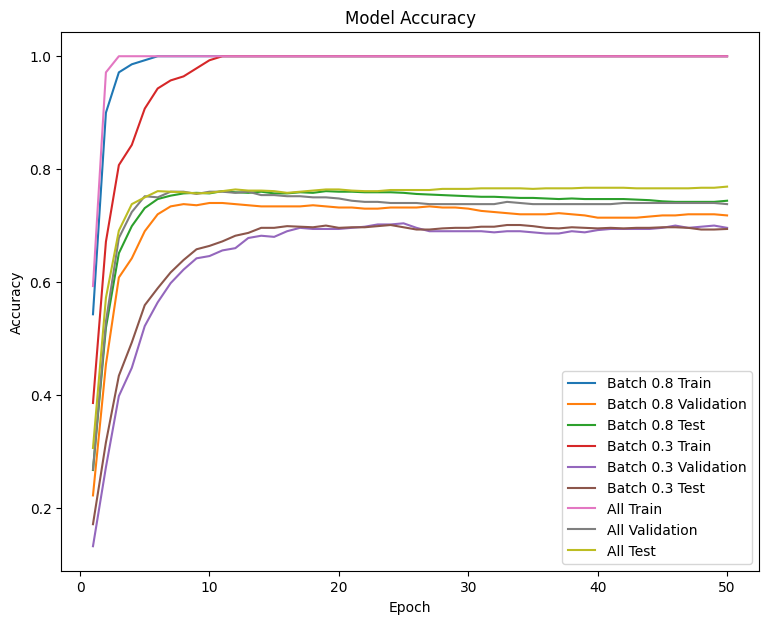

In [29]:
import numpy as np
from matplotlib import pyplot as plt

if 'IS_GRADESCOPE_ENV' not in os.environ:
  batch_results = np.array(batch_accs)
  batch_results_1 = np.array(batch_accs_1)
  all_results = np.array(all_accs)

  x = np.arange(1, 51)

  plt.figure(figsize=(9, 7))

  plt.plot(x, batch_results[:, 0], label="Batch 0.8 Train")
  plt.plot(x, batch_results[:, 1], label="Batch 0.8 Validation")
  plt.plot(x, batch_results[:, 2], label="Batch 0.8 Test")
  plt.plot(x, batch_results_1[:, 0], label="Batch 0.3 Train")
  plt.plot(x, batch_results_1[:, 1], label="Batch 0.3 Validation")
  plt.plot(x, batch_results_1[:, 2], label="Batch 0.3 Test")
  plt.plot(x, all_results[:, 0], label="All Train")
  plt.plot(x, all_results[:, 1], label="All Validation")
  plt.plot(x, all_results[:, 2], label="All Test")
  plt.title('Model Accuracy')
  plt.ylabel('Accuracy')
  plt.xlabel('Epoch')
  plt.legend()
  plt.show()

**NOTE:** We always evaluate accuracy in full-batch mode. Namely, only during training do we use neighborhood sub-sampling. We do this for a couple reason: 1) fairness of comparison, 2) we worry most about computational cost during training as compared to evaluation, and 3) during the inference phase we want to leverage as much neighborhood information as possible!  

# 2) Cluster Sampling

As discussed in Module 7.2, we can also use subgraph (cluster) sampling to scale up GNN. Specifically, we will explore the methods proposed in Cluster-GCN ([Chiang et al. (2019)](https://arxiv.org/abs/1905.07953)), where we break our graph into smaller subgraphs to avoid the computational cost of training on the entire graph at once.

In this final section, we will implement a vanilla Cluster-GCN and experiment with 3 different community partition algorithms.

**NOTE:** the code in this section requires that you have run the `Setup`, `GNN Model` and `Training and Testing` cells of section 2.

## Setup

In [30]:
import copy
import torch
import random
import numpy as np
import networkx as nx
import torch.nn as nn
import pandas as pd
import torch.nn.functional as F
import community.community_louvain as community_louvain

from torch_geometric.nn import SAGEConv
from torch.utils.data import DataLoader
from torch_geometric.datasets import Planetoid
from torch.nn import Sequential, Linear, ReLU
from deepsnap.dataset import GraphDataset
from deepsnap.graph import Graph

if 'IS_GRADESCOPE_ENV' not in os.environ:
  pyg_dataset = Planetoid('./tmp', "Cora")

In [31]:
args = {
    'device': torch.device('cuda' if torch.cuda.is_available() else 'cpu'),
    'dropout': 0.5,
    'num_layers': 2,
    'hidden_size': 64,
    'lr': 0.005,
    'epochs': 150,
}

## Partitioning the Graph into Clusters

We will experiment with three community detection / partition algorithms to partition our graph into different clusters:
* [Kernighan–Lin algorithm (bisection)](https://networkx.org/documentation/stable/reference/algorithms/generated/networkx.algorithms.community.kernighan_lin.kernighan_lin_bisection.html)
* [Clauset-Newman-Moore greedy modularity maximization](https://networkx.org/documentation/stable/reference/algorithms/generated/networkx.algorithms.community.modularity_max.greedy_modularity_communities.html#networkx.algorithms.community.modularity_max.greedy_modularity_communities)
* [Louvain algorithm](https://python-louvain.readthedocs.io/en/latest/api.html)


As a preprocessing step, we partition our graph into a list of seperate subgraphs using one of the three communitiy detection algorithms above. Then during training we iteratively train our vanilla Cluster-GNN model on a randomly selected subgraph, rather than on over the entire graph at once. To make training more stable, we discard any communities that have less than 10 nodes.

Let's begin by defining the three partition algorithms.

In [59]:
def partition(G, method="louvain"):
    # TODO: Implement a function that takes a Networkx graph G and
    # partitions the graph into communities using the specified graph
    # partition algorithm.
    #
    # Return: A list of sets of nodes, one for each community!

    communities = None

    if method == "louvain":
        ############# Your code here #############
        ## (~9 line of code)
        ## Note:
        ## 1. Find a community mapping corresponding to the partition of the
        ##    graph nodes which maximizes the modularity for the Louvain algorithm.
        ##    Set your resolution to 10.
        ## 2. Create a mapping of communities to a set of member nodes.
        ## 3. Extract the node sets from each community and return
        ##    as a list of sets.
        ##    Hint: Perhaps a dictionary structure can assist.
        ## 4. SET random_state = 8
        nodes_map = community_louvain.best_partition(G, resolution=10, random_state=8) # dict w nodes as keys and community as values
        communities_map = {}
        for community in set(nodes_map.values()):
          communities_map[community]=set()
        for node in nodes_map:
          communities_map[nodes_map[node]].add(node)
        # print("Communities: ", len(communities_map))
        # print(communities_map)
        communities = list(communities_map.values())
        ##########################################
    elif method == "bisection":
        ############# Your code here #############
        ## (~1 line of code)
        ## Note:
        ## 1. The Kernigan-Lin algorithm ensures that nodes are partitioned into two
        ##    primary communities.
        ## 2. Ensure that the resultant data structure is consistent with expected
        ##    output.
        ## 3. SET seed = 8
        communities = nx.algorithms.community.kernighan_lin_bisection(G, seed=8)
        ##########################################
    elif method == "greedy":
        ############# Your code here #############
        ## (~1 line of code)
        ## Note:
        ## 1. Clauset-Newman-Moore greedy modularity maximization joins pair
        ##    of communities nodes that most increases modularity until no such
        ##    pair exists.
        communities = nx.community.greedy_modularity_communities(G)
        ##########################################

    return communities


def preprocess(G, node_label_index, method="louvain"):
    graphs = []
    labeled_nodes = set(node_label_index.tolist())
    communities = partition(G, method)
    for community in communities:
        nodes = set(community)
        subgraph = G.subgraph(nodes)
        # Make sure each subgraph has more than 10 nodes
        if subgraph.number_of_nodes() > 10:
            node_mapping = {node : i for i, node in enumerate(subgraph.nodes())}
            subgraph = nx.relabel_nodes(subgraph, node_mapping)
            # Get the id of the training set labeled node in the new graph
            train_label_index = []
            for node in labeled_nodes:
                if node in node_mapping:
                    # Append relabeled labeled node index
                    train_label_index.append(node_mapping[node])

            # Make sure the subgraph contains at least one training set labeled node
            if len(train_label_index) > 0:
                dg = Graph(subgraph)
                # Update node_label_index
                dg.node_label_index = torch.tensor(train_label_index, dtype=torch.long)
                graphs.append(dg)
    return graphs

## Experimenting with different graph partition algorithms

We will now experiment with the three graph partition algorithms, using the resulting graph clusters to train our vanilla Cluster-GNN. We will first observe how each parition algorithm partitions the original graph. Then we will compare the perfomance of our vanilla Cluster-GNN trained using the different graph clustering techniques. Lastly, we will compare against training a vanilla GCN over the entire graph (refered to as Full-Batch training).  

## **Question 2.1a:** How does the Louvain algorithm partition our graph? (3 points)


In [60]:
if 'IS_GRADESCOPE_ENV' not in os.environ:

  set_seed()

  graphs_train, graphs_val, graphs_test = \
      GraphDataset.pyg_to_graphs(pyg_dataset, verbose=True, fixed_split=True)

  graph_train = graphs_train[0]
  graph_val = graphs_val[0]
  graph_test = graphs_test[0]
  graphs = preprocess(graph_train.G, graph_train.node_label_index, method="louvain")
  print()
  print("Partitioning the graph in to {} communities".format(len(graphs)))
  avg_num_nodes = 0
  avg_num_edges = 0
  for graph in graphs:
      avg_num_nodes += graph.num_nodes
      avg_num_edges += graph.num_edges
  avg_num_nodes = int(avg_num_nodes / len(graphs))
  avg_num_edges = int(avg_num_edges / len(graphs))
  print("Each community has {} nodes in average".format(avg_num_nodes))
  print("Each community has {} edges in average".format(avg_num_edges))

Index fields: val_mask ignored.
Index fields: train_mask ignored.
Index fields: test_mask ignored.

Partitioning the graph in to 77 communities
Each community has 21 nodes in average
Each community has 30 edges in average


## **Question 2.1b:** Using Louvain clustering, what is the maximum test accuracy obtained by your vanilla Cluster-GCN? (6 points)


In [61]:
if 'IS_GRADESCOPE_ENV' not in os.environ:

  set_seed()

  model = GNN(graph_train.num_node_features, args['hidden_size'], graph_train.num_node_labels, args).to(args['device'])

  # Disable compile as this does not seem to work yet in PyTorch 2.0.1/PyG 2.3.1
  # try:
  #   model = torch_geometric.compile(model)
  #   print(f"GNN Model compiled")
  # except Exception as err:
  #   print(f"Model compile not supported: {err}")

  optimizer = torch.optim.Adam(model.parameters(), lr=args['lr'])
  louvain_best_model, louvain_accs = train(graphs, [graph_train, graph_val, graph_test], args, model, optimizer, mode="community")
  train_acc, val_acc, test_acc = test([graph_train, graph_val, graph_test], louvain_best_model, save_model_results=True, batch_type="cluster", title="louvain")
  print('Best model:',
        f'Train: {100 * train_acc:.2f}%, '
        f'Valid: {100 * val_acc:.2f}% '
        f'Test: {100 * test_acc:.2f}%')

Epoch: 01, Loss: 2.3312, Train: 13.57%, Valid: 8.00% Test: 9.40%
Epoch: 02, Loss: 1.7699, Train: 20.71%, Valid: 8.40% Test: 11.90%
Epoch: 03, Loss: 1.9551, Train: 20.00%, Valid: 9.80% Test: 12.50%
Epoch: 04, Loss: 1.3844, Train: 17.86%, Valid: 10.00% Test: 12.40%
Epoch: 05, Loss: 3.1564, Train: 17.86%, Valid: 10.20% Test: 13.10%
Epoch: 06, Loss: 2.4857, Train: 17.14%, Valid: 11.80% Test: 14.00%
Epoch: 07, Loss: 3.5326, Train: 18.57%, Valid: 10.80% Test: 13.10%
Epoch: 08, Loss: 2.3947, Train: 19.29%, Valid: 11.20% Test: 13.60%
Epoch: 09, Loss: 2.6751, Train: 19.29%, Valid: 12.60% Test: 14.20%
Epoch: 10, Loss: 1.9691, Train: 21.43%, Valid: 12.20% Test: 14.80%
Epoch: 11, Loss: 2.2476, Train: 22.14%, Valid: 12.60% Test: 14.30%
Epoch: 12, Loss: 2.1253, Train: 23.57%, Valid: 12.20% Test: 12.90%
Epoch: 13, Loss: 1.6954, Train: 20.71%, Valid: 10.60% Test: 12.10%
Epoch: 14, Loss: 1.9079, Train: 21.43%, Valid: 8.40% Test: 10.30%
Epoch: 15, Loss: 3.8391, Train: 22.14%, Valid: 7.40% Test: 9.40%
Ep

## **Question 2.2a:** How does the Bisection algorithm partition our graph? (3 points)

In [62]:
if 'IS_GRADESCOPE_ENV' not in os.environ:

  set_seed()

  graphs_train, graphs_val, graphs_test = \
      GraphDataset.pyg_to_graphs(pyg_dataset, verbose=True, fixed_split=True)

  graph_train = graphs_train[0]
  graph_val = graphs_val[0]
  graph_test = graphs_test[0]
  graphs = preprocess(graph_train.G, graph_train.node_label_index, method="bisection")
  print("Partition the graph in to {} communities".format(len(graphs)))
  avg_num_nodes = 0
  avg_num_edges = 0
  for graph in graphs:
      avg_num_nodes += graph.num_nodes
      avg_num_edges += graph.num_edges
  avg_num_nodes = int(avg_num_nodes / len(graphs))
  avg_num_edges = int(avg_num_edges / len(graphs))
  print("Each community has {} nodes in average".format(avg_num_nodes))
  print("Each community has {} edges in average".format(avg_num_edges))

Index fields: val_mask ignored.
Index fields: train_mask ignored.
Index fields: test_mask ignored.
Partition the graph in to 2 communities
Each community has 1354 nodes in average
Each community has 2397 edges in average


## **Question 2.2b:** Using the Bisection algorithm to partition the graph, what is the maximum test accuracy obtained by your vanilla Cluster-GCN? (6 points)


In [63]:
if 'IS_GRADESCOPE_ENV' not in os.environ:

  set_seed()

  model = GNN(graph_train.num_node_features, args['hidden_size'], graph_train.num_node_labels, args).to(args['device'])

  # Disable compile as this does not seem to work yet in PyTorch 2.0.1/PyG 2.3.1
  # try:
  #   model = torch_geometric.compile(model)
  #   print(f"GNN Model compiled")
  # except Exception as err:
  #   print(f"Model compile not supported: {err}")

  optimizer = torch.optim.Adam(model.parameters(), lr=args['lr'])
  bisection_best_model, bisection_accs = train(graphs, [graph_train, graph_val, graph_test], args, model, optimizer, mode="community")
  train_acc, val_acc, test_acc = test([graph_train, graph_val, graph_test], bisection_best_model, save_model_results=True, batch_type="cluster", title="bisection")
  print('Best model:',
        f'Train: {100 * train_acc:.2f}%, '
        f'Valid: {100 * val_acc:.2f}% '
        f'Test: {100 * test_acc:.2f}%')

Epoch: 01, Loss: 2.0529, Train: 27.86%, Valid: 8.00% Test: 11.40%
Epoch: 02, Loss: 0.9727, Train: 39.29%, Valid: 11.60% Test: 14.40%
Epoch: 03, Loss: 1.9658, Train: 60.71%, Valid: 24.20% Test: 28.10%
Epoch: 04, Loss: 0.3075, Train: 81.43%, Valid: 39.60% Test: 42.80%
Epoch: 05, Loss: 0.2130, Train: 92.86%, Valid: 52.80% Test: 51.80%
Epoch: 06, Loss: 0.1439, Train: 96.43%, Valid: 56.60% Test: 58.00%
Epoch: 07, Loss: 0.5617, Train: 97.86%, Valid: 63.00% Test: 63.00%
Epoch: 08, Loss: 0.0469, Train: 99.29%, Valid: 65.40% Test: 65.40%
Epoch: 09, Loss: 0.0303, Train: 99.29%, Valid: 66.20% Test: 67.10%
Epoch: 10, Loss: 0.2082, Train: 100.00%, Valid: 68.20% Test: 68.80%
Epoch: 11, Loss: 0.1262, Train: 100.00%, Valid: 69.20% Test: 69.60%
Epoch: 12, Loss: 0.0142, Train: 100.00%, Valid: 70.40% Test: 70.20%
Epoch: 13, Loss: 0.0139, Train: 100.00%, Valid: 70.80% Test: 70.50%
Epoch: 14, Loss: 0.0037, Train: 100.00%, Valid: 70.80% Test: 70.90%
Epoch: 15, Loss: 0.0561, Train: 100.00%, Valid: 70.40% Tes

## **Question 2.3a:** How does Greedy preprocessing partition our graph? (3 points)

In [64]:
if 'IS_GRADESCOPE_ENV' not in os.environ:

  set_seed()

  graphs_train, graphs_val, graphs_test = \
      GraphDataset.pyg_to_graphs(pyg_dataset, verbose=True, fixed_split=True)

  graph_train = graphs_train[0]
  graph_val = graphs_val[0]
  graph_test = graphs_test[0]
  graphs = preprocess(graph_train.G, graph_train.node_label_index, method="greedy")
  print("Partition the graph in to {} communities".format(len(graphs)))
  avg_num_nodes = 0
  avg_num_edges = 0
  for graph in graphs:
      avg_num_nodes += graph.num_nodes
      avg_num_edges += graph.num_edges
  avg_num_nodes = int(avg_num_nodes / len(graphs))
  avg_num_edges = int(avg_num_edges / len(graphs))
  print("Each community has {} nodes in average".format(avg_num_nodes))
  print("Each community has {} edges in average".format(avg_num_edges))

Index fields: val_mask ignored.
Index fields: train_mask ignored.
Index fields: test_mask ignored.
Partition the graph in to 20 communities
Each community has 121 nodes in average
Each community has 222 edges in average


## **Question 2.3b:** Using Greedy preprocessing to partition the graph, what is the maximum test accuracy obtained by your vanilla Cluster-GCN? (6 points)

In [65]:
if 'IS_GRADESCOPE_ENV' not in os.environ:

  set_seed()

  model = GNN(graph_train.num_node_features, args['hidden_size'], graph_train.num_node_labels, args).to(args['device'])

  # Disable compile as this does not seem to work yet in PyTorch 2.0.1/PyG 2.3.1
  # try:
  #   model = torch_geometric.compile(model)
  #   print(f"GNN Model compiled")
  # except Exception as err:
  #   print(f"Model compile not supported: {err}")

  optimizer = torch.optim.Adam(model.parameters(), lr=args['lr'])
  greedy_best_model, greedy_accs = train(graphs, [graph_train, graph_val, graph_test], args, model, optimizer, mode="community")
  train_acc, val_acc, test_acc = test([graph_train, graph_val, graph_test], greedy_best_model, save_model_results=True, batch_type="cluster", title="greedy")
  print('Best model:',
        f'Train: {100 * train_acc:.2f}%, '
        f'Valid: {100 * val_acc:.2f}% '
        f'Test: {100 * test_acc:.2f}%')

Epoch: 01, Loss: 2.0095, Train: 19.29%, Valid: 19.20% Test: 21.80%
Epoch: 02, Loss: 2.5608, Train: 17.86%, Valid: 27.00% Test: 28.80%
Epoch: 03, Loss: 2.2371, Train: 23.57%, Valid: 21.00% Test: 25.60%
Epoch: 04, Loss: 0.3521, Train: 22.14%, Valid: 15.60% Test: 17.90%
Epoch: 05, Loss: 1.3821, Train: 22.86%, Valid: 16.00% Test: 19.60%
Epoch: 06, Loss: 2.1014, Train: 22.14%, Valid: 23.20% Test: 26.00%
Epoch: 07, Loss: 2.3317, Train: 22.14%, Valid: 25.60% Test: 27.80%
Epoch: 08, Loss: 1.2040, Train: 24.29%, Valid: 29.40% Test: 30.20%
Epoch: 09, Loss: 3.6556, Train: 24.29%, Valid: 30.00% Test: 31.30%
Epoch: 10, Loss: 2.5275, Train: 23.57%, Valid: 30.60% Test: 31.50%
Epoch: 11, Loss: 2.3284, Train: 24.29%, Valid: 31.00% Test: 31.40%
Epoch: 12, Loss: 2.7586, Train: 28.57%, Valid: 31.40% Test: 31.20%
Epoch: 13, Loss: 2.1814, Train: 36.43%, Valid: 30.40% Test: 30.70%
Epoch: 14, Loss: 0.0951, Train: 40.00%, Valid: 29.40% Test: 30.60%
Epoch: 15, Loss: 0.5107, Train: 45.00%, Valid: 28.20% Test: 30

## Full-Batch Training

In [66]:
if 'IS_GRADESCOPE_ENV' not in os.environ:

  set_seed()

  graphs_train, graphs_val, graphs_test = \
      GraphDataset.pyg_to_graphs(pyg_dataset, verbose=True, fixed_split=True)

  graph_train = graphs_train[0]
  graph_val = graphs_val[0]
  graph_test = graphs_test[0]

  model = GNN(graph_train.num_node_features, args['hidden_size'], graph_train.num_node_labels, args).to(args['device'])

  # Disable compile as this does not seem to work yet in PyTorch 2.0.1/PyG 2.3.1
  # try:
  #   model = torch_geometric.compile(model)
  #   print(f"GNN Model compiled")
  # except Exception as err:
  #   print(f"Model compile not supported: {err}")

  optimizer = torch.optim.Adam(model.parameters(), lr=args['lr'])
  graphs = [graph_train, graph_val, graph_test]
  all_best_model, all_accs = train(graphs, graphs, args, model, optimizer, mode="all")
  train_acc, val_acc, test_acc = test([graph_train, graph_val, graph_test], all_best_model)
  print('Best model:',
        f'Train: {100 * train_acc:.2f}%, '
        f'Valid: {100 * val_acc:.2f}% '
        f'Test: {100 * test_acc:.2f}%')

Index fields: val_mask ignored.
Index fields: train_mask ignored.
Index fields: test_mask ignored.
Epoch: 01, Loss: 2.0470, Train: 59.29%, Valid: 26.80% Test: 30.60%
Epoch: 02, Loss: 1.1333, Train: 97.14%, Valid: 53.00% Test: 57.20%
Epoch: 03, Loss: 0.6012, Train: 100.00%, Valid: 67.80% Test: 69.10%
Epoch: 04, Loss: 0.2909, Train: 100.00%, Valid: 72.40% Test: 73.80%
Epoch: 05, Loss: 0.1524, Train: 100.00%, Valid: 75.20% Test: 75.00%
Epoch: 06, Loss: 0.0756, Train: 100.00%, Valid: 75.00% Test: 76.10%
Epoch: 07, Loss: 0.0394, Train: 100.00%, Valid: 76.00% Test: 76.00%
Epoch: 08, Loss: 0.0200, Train: 100.00%, Valid: 76.00% Test: 75.90%
Epoch: 09, Loss: 0.0105, Train: 100.00%, Valid: 75.60% Test: 75.70%
Epoch: 10, Loss: 0.0046, Train: 100.00%, Valid: 76.00% Test: 75.80%
Epoch: 11, Loss: 0.0048, Train: 100.00%, Valid: 76.00% Test: 76.10%
Epoch: 12, Loss: 0.0061, Train: 100.00%, Valid: 75.80% Test: 76.40%
Epoch: 13, Loss: 0.0033, Train: 100.00%, Valid: 76.00% Test: 76.20%
Epoch: 14, Loss: 0.

## Visualization

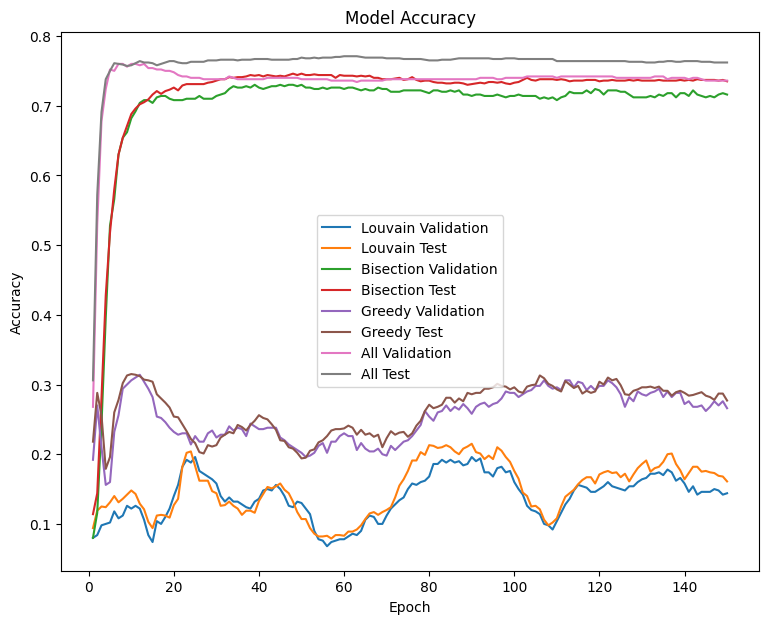

In [67]:
import numpy as np
from matplotlib import pyplot as plt

if 'IS_GRADESCOPE_ENV' not in os.environ:
  louvain_results = np.array(louvain_accs)
  bisection_results = np.array(bisection_accs)
  greedy_results = np.array(greedy_accs)
  all_results = np.array(all_accs)

  x = np.arange(1, 151)

  plt.figure(figsize=(9, 7))

  plt.plot(x, louvain_results[:, 1], label="Louvain Validation")
  plt.plot(x, louvain_results[:, 2], label="Louvain Test")
  plt.plot(x, bisection_results[:, 1], label="Bisection Validation")
  plt.plot(x, bisection_results[:, 2], label="Bisection Test")
  plt.plot(x, greedy_results[:, 1], label="Greedy Validation")
  plt.plot(x, greedy_results[:, 2], label="Greedy Test")
  plt.plot(x, all_results[:, 1], label="All Validation")
  plt.plot(x, all_results[:, 2], label="All Test")
  plt.title('Model Accuracy')
  plt.ylabel('Accuracy')
  plt.xlabel('Epoch')
  plt.legend()
  plt.show()

# Submission

You will need to submit three files on Gradescope to complete this notebook.

1.   Your completed *XCS224W_Colab5.ipynb*. From the "File" menu select "Download .ipynb" to save a local copy of your completed Colab.
2.  *CORA_Node_batch_(0.7,0.9,1).csv*
3.  *CORA_Node_batch_(0.3,0.5,1).csv*
4.  *CORA_Node_cluster_louvain.csv*
5.  *CORA_Node_cluster_greedy.csv*
6.  *CORA_Node_cluster_bisection.csv*

Download the csv files by selecting the *Folder* icon on the left panel.

To submit your work, zip the files downloaded in steps 1-7 above and submit to gradescope. **NOTE:** DO NOT rename any of the downloaded files.